In [2]:
library(dplyr)
library(tidyverse)
library(magrittr)
library(MASS)
library(class)
library(caret)
library(VGAM)
library(randomForest)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   2.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: stats

In [3]:
# transformed data import
star_sub <- read.csv("./Rdata/PhaseA_star_subset.csv")
kNN_star_subset_rf <- read.csv("./kNN_data/kNN_PhaseA_star_subset_rf.csv")
kNN_star_subset_perm <- read.csv("./kNN_data/kNN_PhaseA_star_subset_perm.csv")

In [7]:
# glance of different feature subset 
cat("Feature Subset For Multinomial and RF")
star_sub %>% colnames()
cat("Feature Subset For kNN using RF")
kNN_star_subset_rf %>% colnames()
cat("Feature Subset For kNN using Permutation")
kNN_star_subset_perm %>%colnames()

Feature Subset For Multinomial and RF

[1] "X"        "alpha"    "delta"    "u"        "i"        "redshift"
 [7] "plate"    "MJD"      "fiber_ID" "cam_col"  "fieldbin" "runbin"  
[13] "class"

Feature Subset For kNN using RF

[1] "X"           "redshift"    "u"           "g"           "r"          
 [6] "i"           "z"           "spec_obj_ID" "plate"       "MJD"        
[11] "class"

Feature Subset For kNN using Permutation

[1] "X"        "u"        "g"        "z"        "redshift" "MJD"     
 [7] "cam_col"  "fieldbin" "runbin"   "class"

In [8]:
# transfer variable types for alogrithms 
star_sub <- star_sub %>% mutate(
  class = factor(class),
  cam_col = factor(cam_col),
  fieldbin = factor(fieldbin),
  runbin = factor(runbin)  
)

# kNN-RF
kNN_star_subset_rf <- kNN_star_subset_rf %>% mutate(class = factor(class))

#kNN-Perm
kNN_star_subset_perm <- kNN_star_subset_perm %>% mutate(class = factor(class), 
                                                        cam_col = factor(cam_col),
                                                        fieldbin = factor(fieldbin),
                                                        runbin = factor(runbin)  )

### Split Phase A subset to train and holdout

In [9]:
# take a subset from transfered data to test prepared methods
set.seed(447)

B_subset_train <- sample_n(star_sub, size = nrow(star_sub) * 0.80,
  replace = FALSE
)

B_subset_holdo <- anti_join(star_sub,
  B_subset_train,
  by = "X"
)



kNN_B_subset_train_rf <- sample_n(kNN_star_subset_rf, size = nrow(kNN_star_subset_rf) * 0.80,
  replace = FALSE
)

kNN_B_subset_holdo_rf <- anti_join(kNN_star_subset_rf,
  kNN_B_subset_train_rf,
  by = "X"
)


kNN_B_subset_train_perm <- sample_n(kNN_star_subset_perm, size = nrow(kNN_star_subset_perm) * 0.80,
  replace = FALSE
)

kNN_B_subset_holdo_perm <- anti_join(kNN_star_subset_perm,
  kNN_B_subset_train_perm,
  by = "X"
)

In [6]:
# # senity check 
# cat("Feature Subset For Multinomial and RF")
# B_subset_train %>% colnames()
# B_subset_holdo %>% colnames()

# cat("Feature Subset For kNN using RF")
# kNN_B_subset_train_rf %>% colnames()
# kNN_B_subset_holdo_rf %>% colnames()

# cat("Feature Subset For kNN using Permutation")
# kNN_B_subset_train_perm %>%colnames()
# kNN_B_subset_holdo_perm %>%colnames()

## Multinominal

In [7]:
# drop ID column, then fit model
options(warn = -1)
multi <- vglm(class~., multinomial, data = B_subset_train[-1])

In [8]:
cat("Multinormal 1")
summary(multi)

Multinormal 1


Call:
vglm(formula = class ~ ., family = multinomial, data = B_subset_train[-1])

Coefficients: 
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept):1            55.57904    3.13890  17.707  < 2e-16 ***
(Intercept):2            52.30737    3.15157  16.597  < 2e-16 ***
alpha:1                   0.01818    0.13221   0.137 0.890644    
alpha:2                  -0.04304    0.16197  -0.266 0.790462    
delta:1                   0.05861    0.13311   0.440 0.659708    
delta:2                   0.14422    0.16554   0.871 0.383616    
u:1                      -0.60453    0.16349  -3.698 0.000218 ***
u:2                      -3.51347    0.20727 -16.951  < 2e-16 ***
i:1                       0.26338    0.14537   1.812 0.070017 .  
i:2                       1.78324    0.19461   9.163  < 2e-16 ***
redshift:1               74.00052    4.01227  18.444  < 2e-16 ***
redshift:2               78.31261    4.01831  19.489  < 2e-16 ***
plate:1                   2.77378    0.44034

In [9]:
multi_pred <- predict(multi , newdata = B_subset_holdo, type = "response") 

In [10]:
# category PI function from course
CategoryPredInterval = function(ProbMatrix,labels)
{ ncases = nrow(ProbMatrix)
    pred50 = rep(NA,ncases);   pred80 = rep(NA,ncases);
     data.frame(pred50); data.frame(pred80);
    for(i in 1:ncases)
    {    
        p = ProbMatrix[i,]
        ip = order(p,decreasing = T)
        pOrdered = p[ip] # decreasing order
        labelsOrdered = labels[ip] # decreasing order
        G = cumsum(pOrdered) # cumulative sum from largest
        k1 = min(which(G >= 0.5)) # level1= 0.5
        k2 = min(which(G >= 0.8)) # level2= 0.8
        pred1 = labelsOrdered[1:k1]
        pred2 = labelsOrdered[1:k2]
        pred50[i] = paste(pred1, collapse = "")
        pred80[i] = paste(pred2, collapse = "")
    }
    data.frame(pred50 = pred50, pred80 = pred80)
}

In [11]:
categMisclassRates = function(predIntervalMatrix, iprint=FALSE)
{ cols = colnames(predIntervalMatrix)
rows = rownames(predIntervalMatrix)
misclass = rep(0,length(rows))
for (i in 1:length(rows))
{ row = predIntervalMatrix[i,]
total = sum(row)
class = rows[i]
count = 0
for (j in 1:length(cols))
    { col = cols[j]
if (grepl(class, col, fixed = TRUE)) { count = count + row[col] }
}
misclass[i] = 1 - count/total
if(iprint) cat("Number of misclassifications for ", class, ":", total - count, "\n")
cat("Misclassification rate for ", class, ": ", round(misclass[i], 3), "\n")
}
cat("Avg Misclassification rate: ", round(mean(misclass[]), 3), "\n")
return(misclass)}

In [12]:
predict_multi_pi <- CategoryPredInterval(multi_pred, c("GALAXY", "QSO", "STAR"))

In [13]:
# 50% PI
multi_pi_50 <- table(B_subset_holdo$class, predict_multi_pi$pred50); multi_pi_50
# 80% PI
multi_pi_80 <- table(B_subset_holdo$class, predict_multi_pi$pred80); multi_pi_80

        
         GALAXY  QSO STAR
  GALAXY   1142   20   23
  QSO        49  350    0
  STAR        0    0  416

        
         GALAXY GALAXYQSO GALAXYSTAR  QSO QSOGALAXY STAR STARGALAXY
  GALAXY   1081        42         19    8        12   15          8
  QSO        30        19          0  316        34    0          0
  STAR        0         0          0    0         0  406         10

In [14]:
mis_multi_pi_50 <- categMisclassRates(multi_pi_50, iprint = TRUE)

Number of misclassifications for  GALAXY : 43 
Misclassification rate for  GALAXY :  0.036 
Number of misclassifications for  QSO : 49 
Misclassification rate for  QSO :  0.123 
Number of misclassifications for  STAR : 0 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.053 


In [15]:
mis_multi_pi_80 <- categMisclassRates(multi_pi_80, iprint=TRUE)

Number of misclassifications for  GALAXY : 23 
Misclassification rate for  GALAXY :  0.019 
Number of misclassifications for  QSO : 30 
Misclassification rate for  QSO :  0.075 
Number of misclassifications for  STAR : 0 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.032 


### Caret KNN 

### kNN - RF

In [16]:
# change all the levels of categorical variables to numeric representation 
# for caret kNN alogrithm
kNN_B_subset_train_rf <- kNN_B_subset_train_rf %>% mutate(class =
                     case_when(class == "GALAXY" ~ "X1",
                               class == "QSO" ~ "X2",
                               class == "STAR" ~ "X3"))
# change class data type
kNN_B_subset_train_rf$class <- factor(kNN_B_subset_train_rf$class) 

In [17]:
sqrt(kNN_B_subset_train_rf %>% nrow())

[1] 89.43713

In [18]:
# make a grid of values to test in cross-validation,
# k usually set as sqrt of observations, 89 in our case. 
# So a wider range of k are tested, from 80 to 100
knnGrid_rf <- expand.grid(k = seq(70,100,2))

For Prof and TA,<br/>Cell below has **6 min** Run Time

In [19]:
# model training, cv is not used 
set.seed(447)
knnFit_rf <- train(class ~ ., # formula
                 data = kNN_B_subset_train_rf[-1], # train data   
                 method = "knn",
                 tuneGrid = knnGrid_rf)

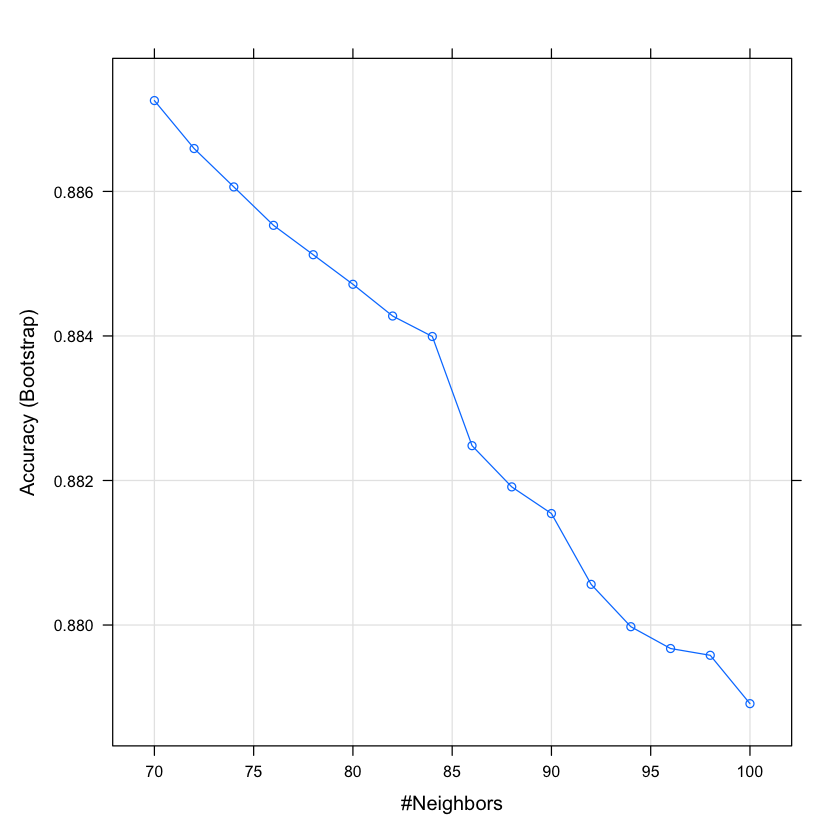

In [20]:
plot(knnFit_rf)

In [21]:
# get prediction result by using the pretrained model and best performed k
pred_class_prob_kNN_rf <- predict(knnFit_rf, newdata = kNN_B_subset_holdo_rf[-1], 'prob')

# convert colnames of prediction and result back to original names 
colnames(pred_class_prob_kNN_rf)<- c("GALAXY","QSO","STAR")

# convert prediction result to matrix data type for PI fucntion 
pred_class_prob_kNN_rf <- data.matrix(pred_class_prob_kNN_rf, rownames.force = T)

In [22]:
pred_class_prob_kNN_rf %>% head()

,GALAXY,QSO,STAR
1,0.38571429,0.04285714,0.5714286
2,0.54285714,0.00000000,0.4571429
3,0.95714286,0.04285714,0.0000000
4,1.00000000,0.00000000,0.0000000
5,0.95714286,0.04285714,0.0000000
6,0.02857143,0.00000000,0.9714286


In [23]:
predict_kNN_pi_rf <- CategoryPredInterval(pred_class_prob_kNN_rf, c("GALAXY", "QSO", "STAR"))

In [24]:
# 50% PI
kNN_pi_50_rf <- table(kNN_B_subset_holdo_rf$class,predict_kNN_pi_rf$pred50); kNN_pi_50_rf
# 80% PI
kNN_pi_80_rf <- table(kNN_B_subset_holdo_rf$class,predict_kNN_pi_rf$pred80); kNN_pi_80_rf

        
         GALAXY GALAXYQSO GALAXYSTAR  QSO QSOGALAXY QSOSTAR STAR STARGALAXY
  GALAXY   1151         0         10   13         0       0   40          3
  QSO        40         1          0  330         2       1    7          2
  STAR      115         0          3    0         0       0  280          0
        
         STARQSO
  GALAXY       2
  QSO          0
  STAR         0

        
         GALAXY GALAXYQSO GALAXYSTAR GALAXYSTARQSO  QSO QSOGALAXY QSOGALAXYSTAR
  GALAXY   1028         9        121             3    3        10             0
  QSO        19        16          6             0  308        14             2
  STAR       33         0         85             0    0         0             0
        
         QSOSTAR QSOSTARGALAXY STAR STARGALAXY STARGALAXYQSO STARQSO
  GALAXY       0             0    9         32             0       3
  QSO          7             2    1          3             1       4
  STAR         0             0  133        145             1       1
        
         STARQSOGALAXY
  GALAXY             1
  QSO                0
  STAR               0

In [25]:
#50% pi
mis_kNN_pi_50_rf <- categMisclassRates(kNN_pi_50_rf, iprint = TRUE);

Number of misclassifications for  GALAXY : 55 
Misclassification rate for  GALAXY :  0.045 
Number of misclassifications for  QSO : 49 
Misclassification rate for  QSO :  0.128 
Number of misclassifications for  STAR : 115 
Misclassification rate for  STAR :  0.289 
Avg Misclassification rate:  0.154 


In [26]:
#80% pi
mis_kNN_pi_80_rf <- categMisclassRates(kNN_pi_80_rf, iprint = TRUE);

Number of misclassifications for  GALAXY : 15 
Misclassification rate for  GALAXY :  0.012 
Number of misclassifications for  QSO : 29 
Misclassification rate for  QSO :  0.076 
Number of misclassifications for  STAR : 33 
Misclassification rate for  STAR :  0.083 
Avg Misclassification rate:  0.057 


### kNN - Perm

In [27]:
# change all the levels of categorical variables to numeric representation 
# for caret kNN alogrithm
# train class
kNN_B_subset_train_perm <- kNN_B_subset_train_perm %>% mutate(class =
                     case_when(class == "GALAXY" ~ "X1",
                               class == "QSO" ~ "X2",
                               class == "STAR" ~ "X3"))

kNN_B_subset_train_perm$class <- factor(kNN_B_subset_train_perm$class) 

# train fieldbin
kNN_B_subset_train_perm <- kNN_B_subset_train_perm %>% mutate(fieldbin =
                             case_when(fieldbin == "(-1.18,-0.774]" ~ 1,
                                       fieldbin == "(-0.774,-0.45]" ~ 2,
                                       fieldbin == "(-0.45,-0.06]" ~ 3,
                                       fieldbin == "(-0.06,0.58]" ~ 4,
                                       fieldbin == "(0.58,5.4]" ~ 5))
kNN_B_subset_train_perm$fieldbin <- factor(kNN_B_subset_train_perm$fieldbin) 

# train runbin
kNN_B_subset_train_perm <- kNN_B_subset_train_perm %>% mutate(runbin =
                     case_when(runbin == "(-2.23,-0.831]" ~ 1,
                               runbin == "(-0.831,-0.327]" ~ 2,
                               runbin == "(-0.327,0.048]" ~ 3,
                               runbin == "(0.048,0.8]" ~ 4,
                               runbin == "(0.8,1.9]" ~ 5))
kNN_B_subset_train_perm$runbin <- factor(kNN_B_subset_train_perm$runbin) 




# holdo fieldbin
kNN_B_subset_holdo_perm <- kNN_B_subset_holdo_perm %>% mutate(fieldbin =
                             case_when(fieldbin == "(-1.18,-0.774]" ~ 1,
                                       fieldbin == "(-0.774,-0.45]" ~ 2,
                                       fieldbin == "(-0.45,-0.06]" ~ 3,
                                       fieldbin == "(-0.06,0.58]" ~ 4,
                                       fieldbin == "(0.58,5.4]" ~ 5))
kNN_B_subset_holdo_perm$fieldbin <- factor(kNN_B_subset_holdo_perm$fieldbin) 


# holdo runbin
kNN_B_subset_holdo_perm <- kNN_B_subset_holdo_perm %>% mutate(runbin =
                     case_when(runbin == "(-2.23,-0.831]" ~ 1,
                               runbin == "(-0.831,-0.327]" ~ 2,
                               runbin == "(-0.327,0.048]" ~ 3,
                               runbin == "(0.048,0.8]" ~ 4,
                               runbin == "(0.8,1.9]" ~ 5))
kNN_B_subset_holdo_perm$runbin <- factor(kNN_B_subset_holdo_perm$runbin) 


In [28]:
# same k as rf
knnGrid_perm <- expand.grid(k = seq(70,100,2))

For Prof and TA,<br/>Cell below has **6 min** Run Time

In [29]:
# model training, cv is not used 
set.seed(447)
knnFit_perm <- train(class ~ ., # formula
                 data = kNN_B_subset_train_perm[-1], # train data   
                 method = "knn",
                 tuneGrid = knnGrid_perm)

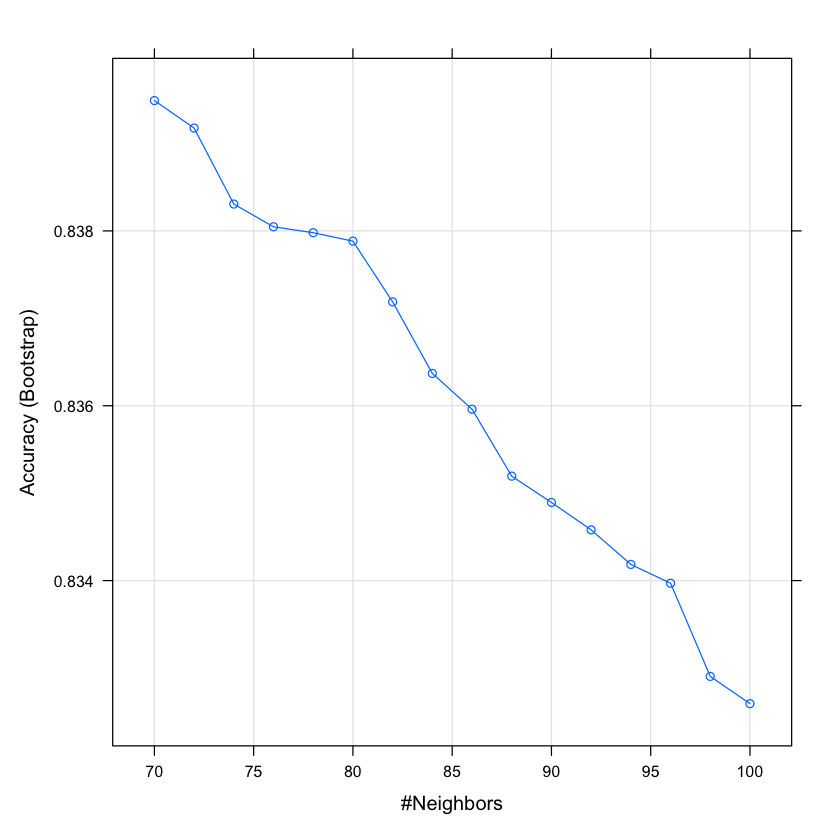

In [30]:
plot(knnFit_perm)

In [31]:
# get prediction result by using the pretrained model and best performed k
pred_class_prob_kNN_perm <- predict(knnFit_perm, newdata = kNN_B_subset_holdo_perm[-1], 'prob')

# convert colnames of prediction and result back to original names 
colnames(pred_class_prob_kNN_perm)<- c("GALAXY","QSO","STAR")

# convert prediction result to matrix data type for PI fucntion 
pred_class_prob_kNN_perm <- data.matrix(pred_class_prob_kNN_perm, rownames.force = T)

In [32]:
# senity check for prediction
pred_class_prob_kNN_perm %>% head()

,GALAXY,QSO,STAR
1,0.8857143,0.00000000,0.11428571
2,0.9571429,0.02857143,0.01428571
3,0.8857143,0.01428571,0.10000000
4,0.9857143,0.00000000,0.01428571
5,0.9714286,0.01428571,0.01428571
6,0.8285714,0.15714286,0.01428571


In [33]:
predict_kNN_pi_perm <- CategoryPredInterval(pred_class_prob_kNN_perm, c("GALAXY", "QSO", "STAR"))

In [34]:
# 50% PI
kNN_pi_50_perm <- table(kNN_B_subset_holdo_perm$class,predict_kNN_pi_perm$pred50); kNN_pi_50_perm
# 80% PI
kNN_pi_80_perm <- table(kNN_B_subset_holdo_perm$class,predict_kNN_pi_perm$pred80); kNN_pi_80_perm

        
         GALAXY GALAXYQSO GALAXYSTAR  QSO QSOGALAXY STAR STARGALAXY STARQSO
  GALAXY   1165         0          3    3         0   17          4       1
  QSO        58         8          0  325         5    3          3       1
  STAR      217         0         12    0         0  166          9       0

        
         GALAXY GALAXYQSO GALAXYQSOSTAR GALAXYSTAR QSO QSOGALAXY QSOGALAXYSTAR
  GALAXY    942        39             0        187   1         2             0
  QSO        21        33             2         10 265        63             1
  STAR       35         0             0        194   0         0             0
        
         QSOSTAR STAR STARGALAXY STARGALAXYQSO STARQSO STARQSOGALAXY
  GALAXY       0    0         20             1       0             1
  QSO          1    0          4             2       1             0
  STAR         0   22        152             0       1             0

In [35]:
#50% pi
mis_kNN_pi_50_perm  <- categMisclassRates(kNN_pi_50_perm , iprint = TRUE);

Number of misclassifications for  GALAXY : 21 
Misclassification rate for  GALAXY :  0.018 
Number of misclassifications for  QSO : 64 
Misclassification rate for  QSO :  0.159 
Number of misclassifications for  STAR : 217 
Misclassification rate for  STAR :  0.537 
Avg Misclassification rate:  0.238 


In [36]:
#80% pi
mis_kNN_pi_80_perm  <- categMisclassRates(kNN_pi_80_perm , iprint = TRUE);

Number of misclassifications for  GALAXY : 1 
Misclassification rate for  GALAXY :  0.001 
Number of misclassifications for  QSO : 35 
Misclassification rate for  QSO :  0.087 
Number of misclassifications for  STAR : 35 
Misclassification rate for  STAR :  0.087 
Avg Misclassification rate:  0.058 


## Random Forest

In [37]:
rf <- randomForest(factor(class) ~ ., data = B_subset_train[-1], ntree = 400)
print(rf)


Call:
 randomForest(formula = factor(class) ~ ., data = B_subset_train[-1],      ntree = 400) 
               Type of random forest: classification
                     Number of trees: 400
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.76%
Confusion matrix:
       GALAXY  QSO STAR  class.error
GALAXY   4757   48   36 0.0173517868
QSO       136 1386    0 0.0893561104
STAR        1    0 1635 0.0006112469


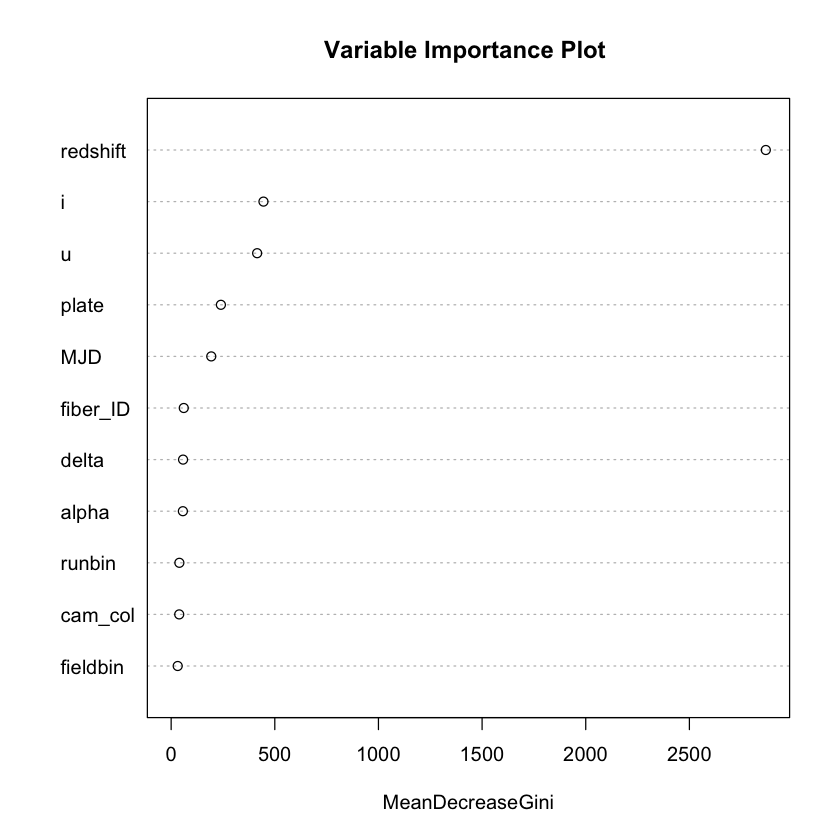

In [38]:
# feature importance
varImpPlot(rf, main = "Variable Importance Plot ")

In [39]:
# prediction 
pred_rf <- predict(rf, newdata = B_subset_holdo,type = "prob")

In [40]:
predint_rf_pi <- CategoryPredInterval(pred_rf, labels=c("GALAXY","QSO", "STAR"))

In [41]:
cat("RF 50% Prediction Interval Table")
rf_pi_50 <- table(B_subset_holdo$class, predint_rf_pi$pred50)
print(rf_pi_50)
cat("RF 80% Prediction Interval Table ")
rf_pi_80 <-  table(B_subset_holdo$class, predint_rf_pi$pred80)
print(rf_pi_50)

RF 50% Prediction Interval Table        
         GALAXY GALAXYQSO  QSO QSOGALAXY STAR
  GALAXY   1155         2   14         0   14
  QSO        34         1  362         2    0
  STAR        0         0    0         0  416
RF 80% Prediction Interval Table         
         GALAXY GALAXYQSO  QSO QSOGALAXY STAR
  GALAXY   1155         2   14         0   14
  QSO        34         1  362         2    0
  STAR        0         0    0         0  416


In [42]:
# 50% misclassification rate
mis_rf_pi_50 <- categMisclassRates(rf_pi_50, iprint=TRUE)

Number of misclassifications for  GALAXY : 28 
Misclassification rate for  GALAXY :  0.024 
Number of misclassifications for  QSO : 34 
Misclassification rate for  QSO :  0.085 
Number of misclassifications for  STAR : 0 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.036 


In [43]:
# 80% misclassification rate
mis_rf_pi_80 <- categMisclassRates(rf_pi_80, iprint=TRUE)

Number of misclassifications for  GALAXY : 15 
Misclassification rate for  GALAXY :  0.013 
Number of misclassifications for  QSO : 16 
Misclassification rate for  QSO :  0.04 
Number of misclassifications for  STAR : 0 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.018 


## Misclassification Rate on Train with Class levels

In [44]:
cat("Multinomial Prediction Interval Table")
mis_multi_result <- round(rbind(mis_multi_pi_50, mis_multi_pi_80),3)
colnames(mis_multi_result) <- c("GALAXY","QSO","STAR")
rownames(mis_multi_result) <- c("50% PI",  "80% PI")
mis_multi_result

Multinomial Prediction Interval Table

,GALAXY,QSO,STAR
50% PI,0.036,0.123,0
80% PI,0.019,0.075,0


In [45]:
cat("kNN - rf Prediction Interval Table")
mis_kNN_result_rf <- round(rbind(mis_kNN_pi_50_rf, mis_kNN_pi_80_rf), 3)
colnames(mis_kNN_result_rf) <- c("GALAXY","QSO","STAR")
rownames(mis_kNN_result_rf) <- c("50% PI",  "80% PI")
mis_kNN_result_rf

kNN - rf Prediction Interval Table

,GALAXY,QSO,STAR
50% PI,0.045,0.128,0.289
80% PI,0.012,0.076,0.083


In [46]:
cat("kNN - Perm Prediction Interval Table")
mis_kNN_result_perm <- round(rbind(mis_kNN_pi_50_perm, mis_kNN_pi_80_perm), 3)
colnames(mis_kNN_result_perm) <- c("GALAXY","QSO","STAR")
rownames(mis_kNN_result_perm) <- c("50% PI",  "80% PI")
mis_kNN_result_perm

kNN - Perm Prediction Interval Table

,GALAXY,QSO,STAR
50% PI,0.018,0.159,0.537
80% PI,0.001,0.087,0.087


In [47]:
cat("Random Forest Prediction Interval Table")
mis_rf_result <- round(rbind(mis_rf_pi_50, mis_rf_pi_80), 3)
colnames(mis_rf_result) <- c("GALAXY","QSO","STAR")
rownames(mis_rf_result) <- c("50% PI",  "80% PI")
mis_rf_result

Random Forest Prediction Interval Table

,GALAXY,QSO,STAR
50% PI,0.024,0.085,0
80% PI,0.013,0.040,0


In [48]:
mis_multi <- round(rbind(mean(mis_multi_pi_50), mean(mis_multi_pi_80)), 3)
mis_kNN_rf <- cbind(round(rbind(mean(mis_kNN_pi_50_rf), mean(mis_kNN_pi_80_rf)), 3))
mis_kNN_perm <- cbind(round(rbind(mean(mis_kNN_pi_50_perm), mean(mis_kNN_pi_80_perm)), 3))
mis_rf <- cbind(round(rbind(mean(mis_rf_pi_50), mean(mis_rf_pi_80)), 3))
holdoms <- cbind(mis_multi, mis_kNN_rf,mis_kNN_perm, mis_rf)
colnames(holdoms) <- c("Multinomial","kNN-rf", "kNN-perm","Random Forest")
rownames(holdoms) <- c("Avg 50% PI",  "Avg 80% PI")

In [49]:
cat("Model Comparison Table")
holdoms

Model Comparison Table

,Multinomial,kNN-rf,kNN-perm,Random Forest
Avg 50% PI,0.053,0.154,0.238,0.036
Avg 80% PI,0.032,0.057,0.058,0.018
